In [37]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from tqdm import tqdm_notebook as tqdm

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [38]:
def date_parser(x):
    return pd.datetime.strptime(x, '%d-%m-%Y %H:%M')

train_data = pd.read_csv('train.csv', index_col = 1, parse_dates = [1], date_parser = date_parser)
test_data = pd.read_csv('test.csv', index_col = 1, parse_dates = [1], date_parser = date_parser)
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
#y = train_data['count'].resample('W').mean()
train_data.head(20)
#train_data = pd.DataFrame(y)
#train_data

,id,count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2
2012-08-25 05:00:00,5,2
2012-08-25 06:00:00,6,2
2012-08-25 07:00:00,7,2
2012-08-25 08:00:00,8,6


In [39]:
train_data.shape

(18288, 2)

In [41]:
train_data.isnull().sum()

id       0
count    0
dtype: int64

In [42]:
test_data.isnull().sum()

id    0
dtype: int64

In [43]:
train_data.dtypes

id       int64
count    int64
dtype: object

In [44]:
train_data.nunique()

id       18288
count      437
dtype: int64

In [45]:
test_ID = test_data['id'].values
test_data = test_data.drop('id', axis = 1)
train_data = train_data.drop('id', axis = 1)
train_data.head()

,count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [46]:
train_data.index[1]

Timestamp('2012-08-25 01:00:00')

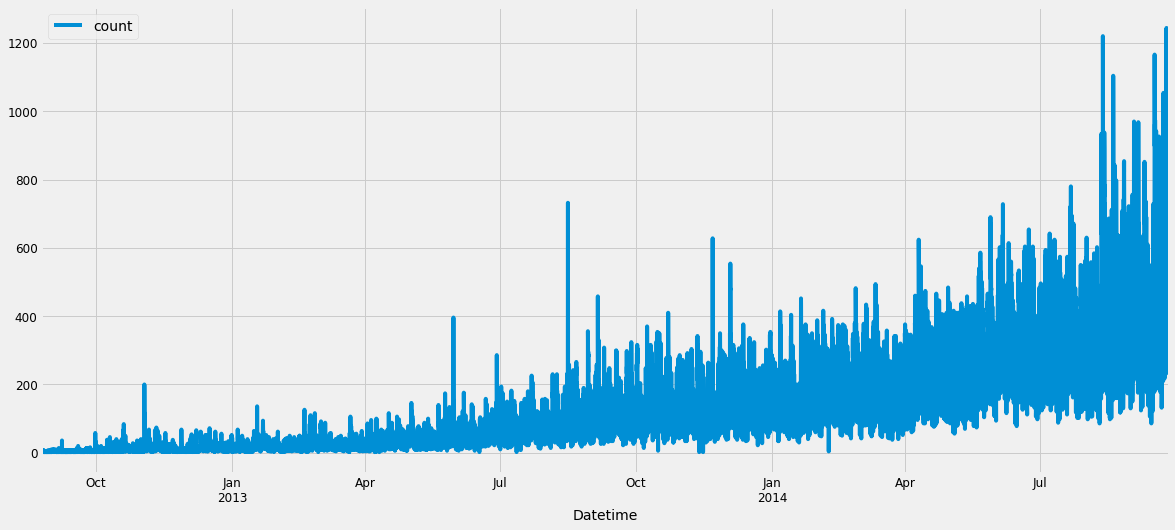

In [47]:
train_data.plot()
plt.show()

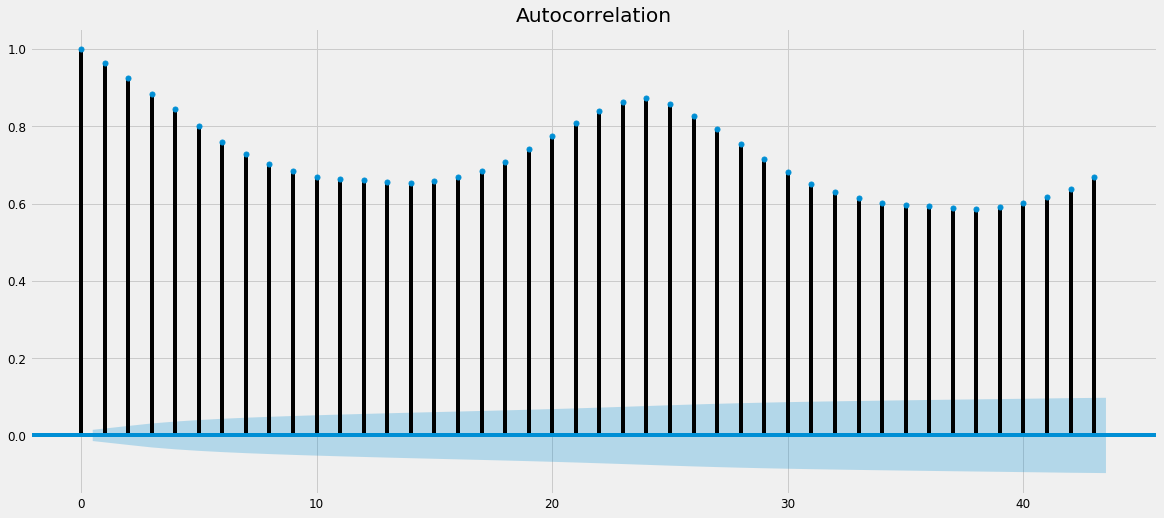

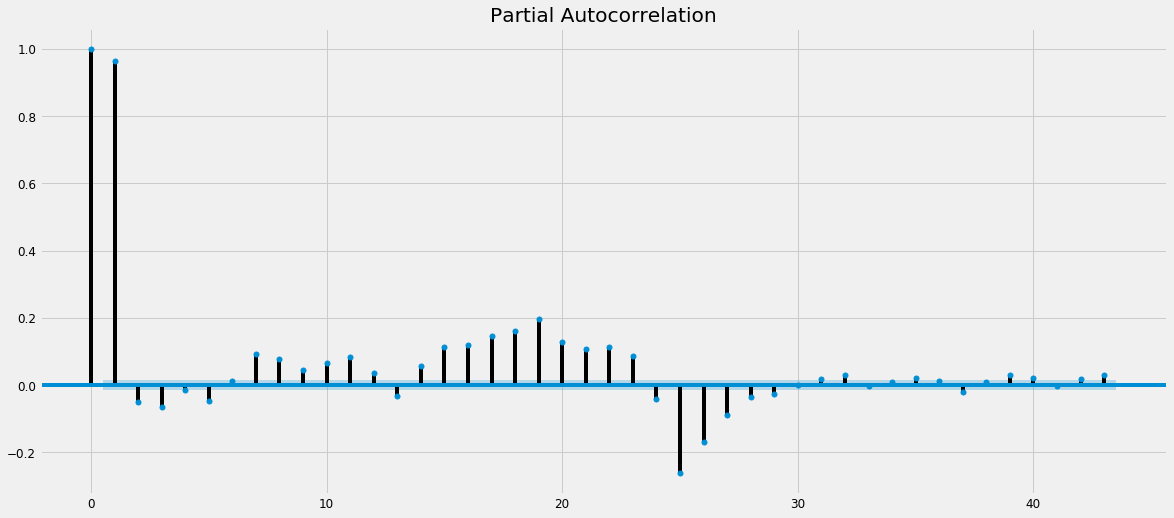

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_data)
plt.show()
plot_pacf(train_data)
plt.show()

## Converting series to stationary

In [55]:
train_data_diff = train_data.diff(periods = 1)
# integrated of order 1, denoted by d (for diff), one of the parameter of ARIMA model
train_data_diff = train_data_diff[1:]
train_data_diff.head()

,count
Datetime,
2012-08-25 01:00:00,-6.0
2012-08-25 02:00:00,4.0
2012-08-25 03:00:00,-4.0
2012-08-25 04:00:00,0.0
2012-08-25 05:00:00,0.0


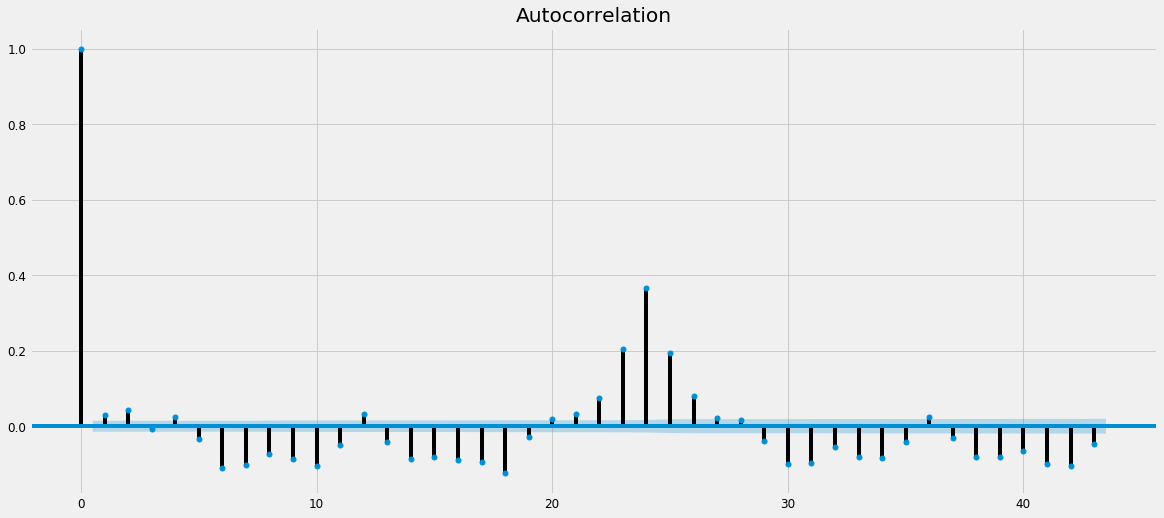

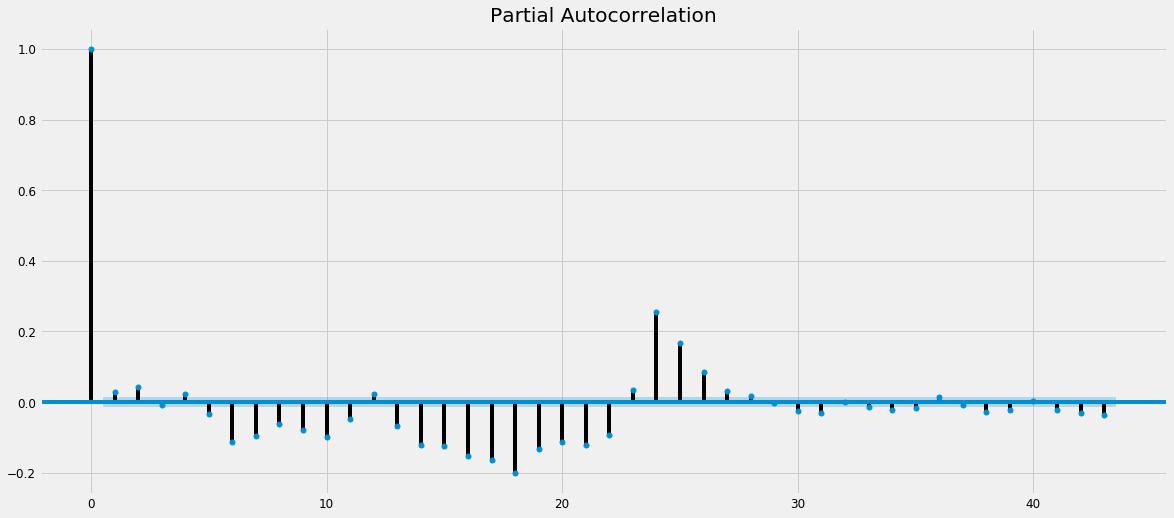

In [56]:
plot_acf(train_data_diff)
plt.show()
plot_pacf(train_data_diff)
plt.show()

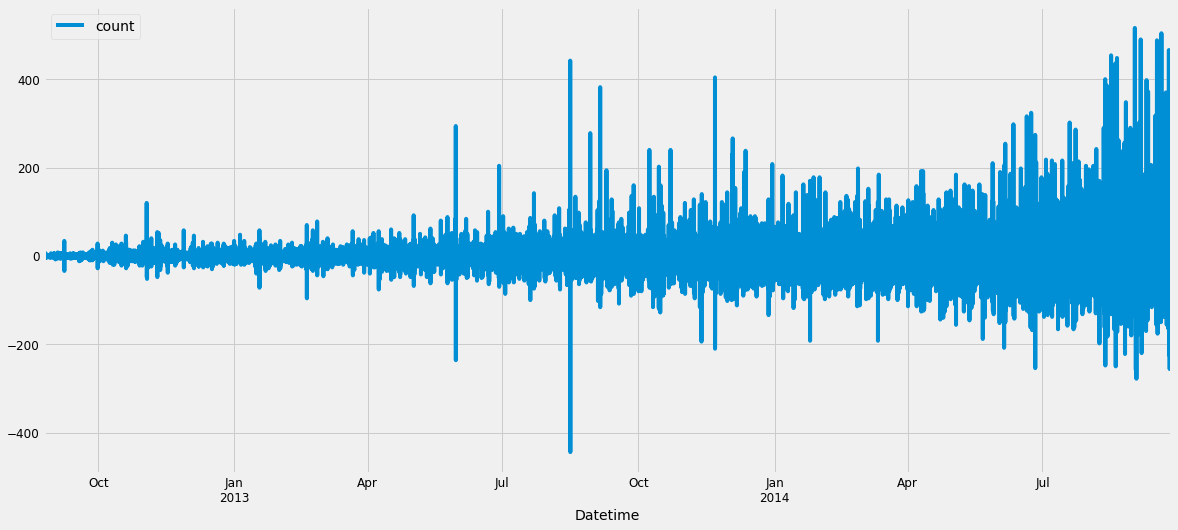

In [57]:
train_data_diff.plot()
plt.show()

In [58]:
X = train_data.values
train = X[0:12802] # 12802 data as train data
test = X[12802:]  # 5486 data as test data
predictions = []

## Autoregressive - AR Model

In [59]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [62]:
predictions = model_ar_fit.predict(start = 12802, end = 18288)

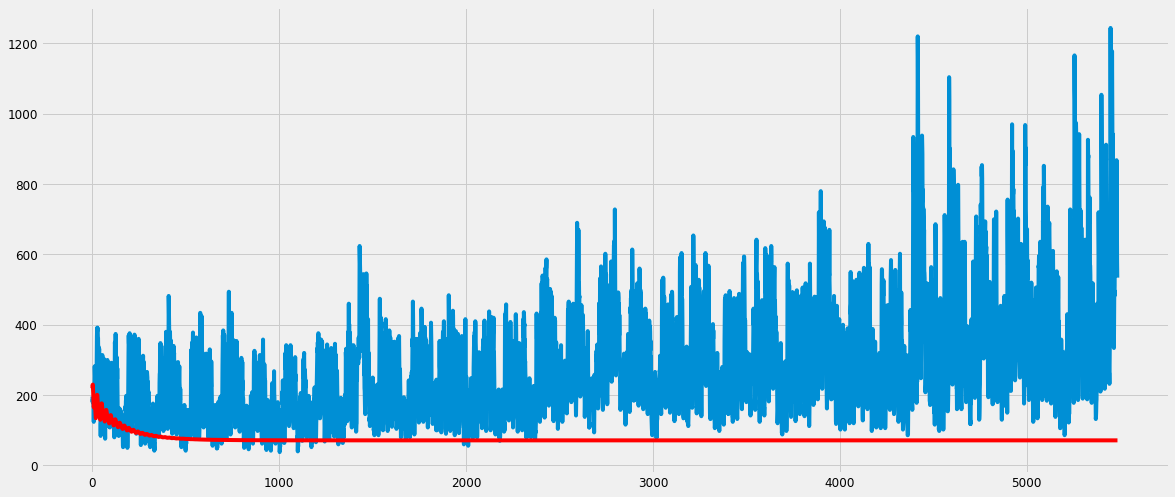

In [63]:
plt.plot(test)
plt.plot(predictions, color = 'red') 
plt.show()

## ARIMA model

In [64]:
from statsmodels.tsa.arima_model import ARIMA

In [65]:
import itertools
p = d = q = range(0, 10)
pdq = list(itertools.product(p, d, q))

In [ ]:
param_aic = {}
for param in tqdm(pdq):
    try:
        model_arima = ARIMA(train, order = param)
        model_arima_fit = model_arima.fit()
        param_aic[param] = model_arima_fit.aic
    except:
        continue

In [ ]:
{k: v for k, v in sorted(param_aic.items(), key = lambda item: item[1])}

In [66]:
# p,d,q  
# p = periods taken for autoregressive model
# d = Integrated order, difference
# q = periods in moving average model

model_arima = ARIMA(train, order = (0, 2, 4))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

118784.29708248372


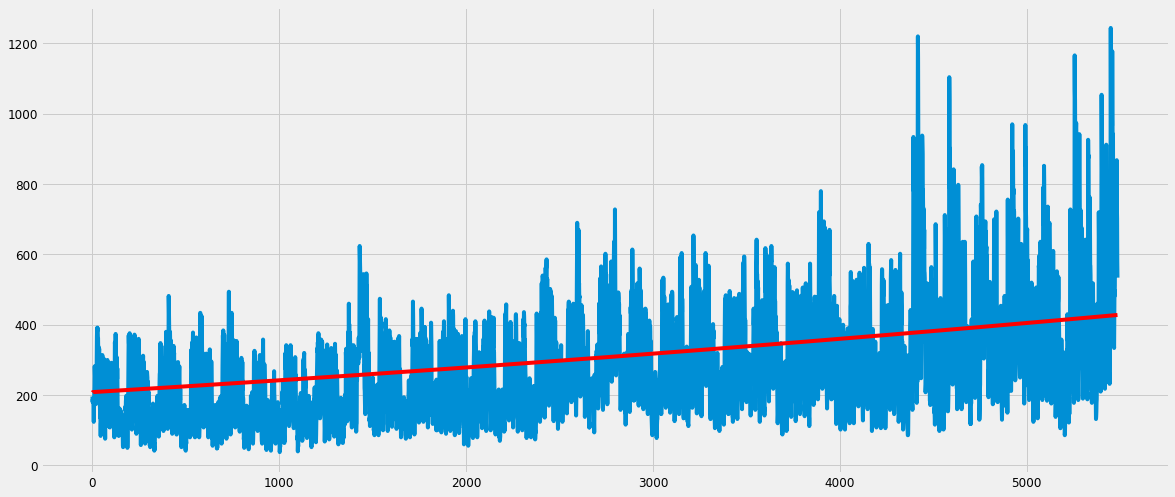

In [69]:
predictions = model_arima_fit.forecast(steps = 5486)[0]
plt.plot(test)
plt.plot(predictions,color = 'red')
plt.show()

In [70]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


In [ ]:
param_aic_seasonal = {}
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            param_aic_seasonal[param] = results.aic
        except:
            continue
{k: v for k, v in sorted(param_aic_seasonal.items(), key = lambda item: item[1])}

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1221      0.003    -39.468      0.000      -0.128      -0.116
ma.S.L12      -0.0152      0.006     -2.580      0.010      -0.027      -0.004
sigma2       627.2514      1.852    338.713      0.000     623.622     630.881


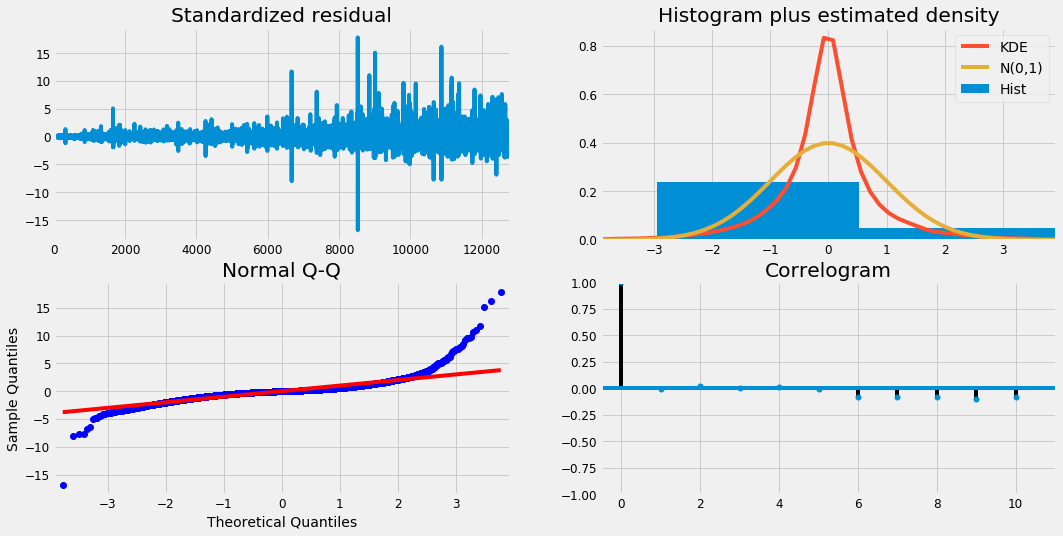

In [71]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order = (0, 1, 1),
                                seasonal_order = (0, 0, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize = (16, 8))
plt.show()

In [36]:
prediction = pd.DataFrame(Arima_model.predict(n_periods = 185), index = test.index)

pred = forecast(results, h = 41)
pred_ci = pred.conf_int()
ax = y['2012':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

NameError: name 'forecast' is not defined

In [73]:
predictions

In [75]:
results.get_forecast(steps = 5486)

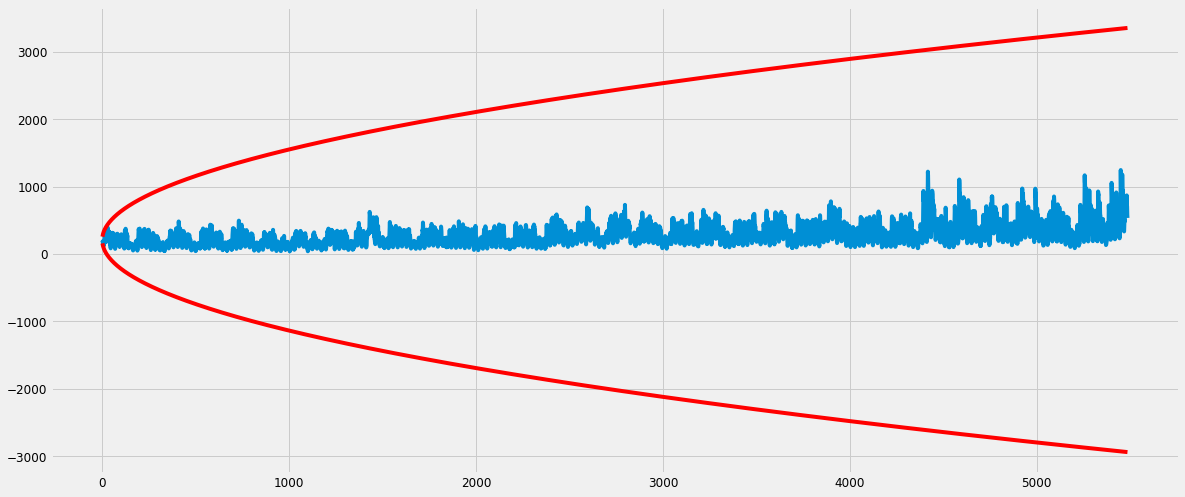

In [76]:
predictions = results.get_forecast(steps = 5486)
predictions = predictions.conf_int(alpha = 0.05)
plt.plot(test)
plt.plot(predictions, color = 'red')
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label = 'observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()